## Imports

In [1]:
############
# Built-in #
############
import ast
from itertools import groupby
import os
import re
import tempfile

###############
# Third-party #
###############
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine

pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
%matplotlib inline

## Database Connection Setup

In [2]:
HOST = 'localhost'
USER = 'db_user'
PORT = 5438
DATABASE = 'msd_db'
PASSWORD = 'LetMeIn'
TABLE_NAME = 'song_info'

# Connect with SQLAlchemy
conn_string = f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}'
sqla_conn = create_engine(conn_string)

## Notebook Functions
Functions that are used throughout this notebook to either help load data or process data.

In [3]:
def read_sql_with_copy(query, db_engine, convert_list_cols=False):
    '''Run a SQL query using the COPY command to reduce RAM usage.
    
    By using a temporary file to run a query, this cuts down on the
    memory usage by utilizing a direct download to CSV rather than 
    dealing with all the overhead that pandas does internally with 
    its built-in `read_sql` function.
    
    Parameters
    ----------
    query : str
        Query string to pass into the database
        
    db_engine : SQLAlchemy engine object
        SQLAlchemy engine for creating connections
        
    convert_list_cols : bool
        If `True`, this will convert any columns that are supposed to be
        lists into actual lists instead of the strings that this method
        returns for those columns.
    '''
    print('Running query...', end = '')
    try:
        with tempfile.TemporaryFile() as tmp:
            copy_sql = f'COPY ({query}) TO STDOUT WITH CSV HEADER'
            conn = db_engine.raw_connection()
            cur = conn.cursor()
            cur.copy_expert(copy_sql, tmp)
            tmp.seek(0)
            df = pd.read_csv(tmp)
    except Exception as e:
        print(e)
    finally:
        cur.close()
        conn.close()
    print('done!')
    
    if convert_list_cols:
        # Get columns that are supposed to be lists
        print('Converting list columns...', end = '')
        list_cols = []
        for col in df.columns:
            try:
                # There is a song containing curly braces in the title so
                # this will pick up on that, hence the extra conditioning
                # on the 'title' column
                if any(df[col].str.contains('{')) and col != 'title': 
                    list_cols.append(col)
            except:
                # If a column doesn't have a `str` attribute, it is not a string
                # column so it should error out above and we can ignore that column
                continue

        # Change curly braces to brackets and change to list
        # using some funky regex here to properly wrap text
        # in double quotes so `ast.literal_eval` works, i.e.,
        # turns '{item_1, item_2, ...}' into '["item_1", "item_2", ...]'
        # so literal evaluation turns it into an actual list
        pattern = re.compile(r'{([\w\s,\-"&]+)}')
        f_inner = lambda x: '{{{}}}'.format(re.sub(r'[\w\s\-&]+', r'"\g<0>"', x.group(1)))
        f_outer = lambda x: ast.literal_eval(
            re.sub(pattern, f_inner, x.replace('"', '')).replace('{', '[').replace('}', ']')
        )
        for col in list_cols:
            df[col] = df[col].apply(f_outer)
        print('done!')
    
    return df

In [4]:
def plot_artist_terms(df):
    '''Plot artist terms by year.
    
    This is a custom plotting function taken and adapted from
    https://stackoverflow.com/questions/58854335/how-to-label-y-ticklabels-as-group-category-in-seaborn-clustermap.
    
    Parameters
    ----------
    df : pandas DataFrame
        DataFrame with artist term data to plot.
    '''
    def _add_line(ax, xpos, ypos):
        '''Helper function to add lines to split up groups.'''
        line = plt.Line2D(
            [xpos, xpos], 
            [ypos + .1, ypos],
            transform = ax.transAxes, 
            color = 'black'
        )
        line.set_clip_on(False);
        ax.add_line(line);
        
    def _label_len(index, level):
        '''Helper function to get the length of labels in each level.'''
        labels = index.get_level_values(level)
        return [(k, sum(1 for i in g)) for k, g in groupby(labels)]
    
    def _label_group_bar_table(ax, df):
        '''Helper function to properly position and add labels to graph.'''
        ypos = -.1
        scale = 1.0 / df.index.size
        for level in range(df.index.nlevels)[::-1]:
            pos = 0
            
            # We need to iterate through each index/group that we want
            # to graph and then adjust the y-axis position so it doesn't
            # overlap with the graph bars
            for label, rpos in _label_len(df.index, level):
                lxpos = (pos + .5 * rpos) * scale
                if level == 1: # This affects only the `artist_term` column
                    ypos_label = -len(label) * 0.01
                    rotation = 90
                else:
                    ypos_label = ypos
                    rotation = 0
                    
                ax.text(
                    lxpos, 
                    ypos_label, 
                    label, 
                    ha = 'center',
                    transform = ax.transAxes, 
                    rotation = rotation
                );
                _add_line(ax, pos * scale, ypos)
                pos += rpos
            _add_line(ax, pos * scale , ypos)
            ypos -= .1
    
    # Re-index input DataFrame so we can properly iterate through
    # the indices and plot them on the graph
    tuples = list(zip(df['year'], df['artist_term']))
    index = pd.MultiIndex.from_tuples(tuples, names = ['year', 'artist_term'])
    min_year = df['year'].min()
    max_year = df['year'].max()
    df = df.set_index(index)[['artist_term_count']]
    
    fig = plt.figure(figsize = (15, 10))
    ax = fig.add_subplot(111)
    df.plot(kind = 'bar', ax = fig.gca());
    
    # Re-label axes with new labels
    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels);
    ax.set_xlabel('');
    ax.set_ylabel('Count');
    ax.set_title(f'Top 3 Artist Terms by Year ({min_year} - {max_year})');
    _label_group_bar_table(ax, df)
    fig.subplots_adjust(bottom = .1 * df.index.nlevels);

## Data Loading
Doing a straight `read_sql` with pandas uses a lot of overhead with the size of our dataset, so we have to use a memory workaround with our custom `read_sql_with_copy` function.

In [5]:
# Example usage of how to get data into
# a DataFrame with the `read_sql_with_copy` function
query = f'''
    SELECT 
        *
    FROM {TABLE_NAME}
    LIMIT 10
 '''

query_df = read_sql_with_copy(
    query = query, 
    db_engine = sqla_conn,
    convert_list_cols = False
)
query_df.head()

Running query...done!


,track_id,song_id,title,track_7digitalid,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,bars_confidence,bars_start,beats_confidence,beats_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,tatums_confidence,tatums_start,artist_terms,artist_terms_freq,artist_terms_weight,similar_artists,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_longitude,artist_location,artist_mbid,artist_name,artist_playmeid,genre,release,release_7digitalid,song_hotttnesss,artist_mbtags,artist_mbtags_count,year
0,TRBGJCT128F933A606,SOBBQDL12A58A7A988,100 Club 1996 ''We Love You Beatles'' - Live,5195440,22050,40f155321c40015d95c7815033a54e15,0,88.73751,0.298,0,2,0.031,-11.229,0,0.331,88.738,190.333,5,0.562,"{0.124,0.112,0.096,0.215,0.054,0.143,0.114,0.1...","{1.05277,2.68331,4.22783,5.88498,7.44629,8.893...","{0.79,0.92,0.696,0.626,0.587,0.519,0.485,0.47,...","{0.04606,0.37526,0.71941,1.05277,1.38778,1.729...","{1.0,0.371,0.166,0.959}","{0.0,35.743,51.07955,83.16827}","{0.0,1.0,0.95,0.212,0.888,0.303,0.343,1.0,0.88...","{-60.0,-14.114,-13.495,-12.97,-13.733,-11.403,...","{0.0,0.14916,0.02785,0.05477,0.08291,0.04679,0...","{-60.0,-60.0,-27.538,-16.692,-25.007,-14.495,-...","{{0.97,1.0,0.502,0.362,0.352,0.377,0.356,0.259...","{0.0,0.29846,0.56594,0.78739,1.04821,1.14653,1...","{{0.0,171.13,9.469,-28.48,57.491,-50.067,14.83...","{0.79,0.92,0.696,0.626,0.587,0.519,0.485,0.47,...","{0.04606,0.37526,0.71941,1.05277,1.38778,1.729...","{punk,italy,""british punk rock"",soundtrack,""pr...","{1.0,0.5596462649523082,0.5100886604134174,0.3...","{1.0,0.7760465835458507,0.7415077362419781,0.4...","{ARNTVM11187B98B4B4,AREKBBQ11F50C4971D,ARNFTGS...",414,0.731184,0.549204,ARD3LXU1187B9ABFC5,NaN,NaN,NaN,e5db18cb-4b1f-496d-a308-548b611090d3,Sex Pistols,1418,NaN,Sex Pistols - The Interviews,467088,NaN,"{british,""punk rock"",uk,london,england,english...","{4,3,3,1,1,1,1,1,1,1}",0
1,TRBGJOG12903CC3E93,SOIZHEV12A8C14138B,Yo Quiero Contigo,7948828,22050,88ff14072530c24e4a71dc36d8cfcd4d,0,167.36608,5.851,0,4,0.049,-8.383,0,0.236,167.366,122.701,5,0.472,"{0.072,0.129,0.13,0.182,0.222,0.037,0.074,0.04...","{1.67692,4.54817,7.04522,9.49961,11.9417,14.38...","{0.349,0.519,0.296,0.501,0.128,0.0,0.427,0.233...","{0.53691,1.10301,1.67692,2.25482,2.82228,3.389...","{1.0,1.0,0.164,0.415,0.501,0.021,0.319,0.447,0...","{0.0,10.4801,42.25348,61.33113,71.11294,94.589...","{1.0,0.171,0.342,0.569,0.868,0.821,0.976,0.502...","{-24.193,-23.662,-26.904,-24.408,-19.328,-26.4...","{0.09915,0.06022,0.07353,0.04847,0.06487,0.044...","{-60.0,-26.43,-30.124,-29.522,-29.05,-37.009,-...","{{0.828,0.564,0.238,0.302,1.0,0.8,0.808,0.586,...","{0.0,0.18848,0.34,0.51361,1.05342,1.25002,1.64...","{{27.46,-55.217,73.516,-97.74,29.328,151.265,7...","{0.256,0.258,0.259,0.26,0.254,0.274,0.271,0.26...","{0.15448,0.35045,0.53691,0.73003,0.91459,1.103...","{reggaeton,""los angeles"",california,""hip hop"",...","{1.0,0.8120981752908923,0.8120981752908923,0.8...","{1.0,0.8843108934201204,0.8139725439930916,0.6...","{AROTGDJ12454A52E29,ARYFNBU12454A4D74D,ARROGBH...",170931,0.610186,0.355320,ARWWPKQ11F4C83D8E2,NaN,NaN,NaN,NaN,Baby Rasta & Gringo,-1,NaN,Sentenciados - Platinum Edition,716669,NaN,{},{},0
2,TRBGJFN128F429AB79,SOHFGYR12A8C13AE07,Vankina vapauden,1170609,22050,77ab2a1f981525fea9c68f3b6958e402,0,189.36118,5.515,0,5,0.142,-10.819,0,0.319,185.481,97.103,3,1.000,"{1.0,0.175,0.103,0.136,0.088,0.243,0.112,0.284...","{1.26612,3.10739,5.00016,6.882,8.75449,10.6566...","{0.0,0.0,0.0,0.0,0.0,0.559,0.74,0.48,0.341,0.3...","{0.64188,1.26612,1.88456,2.47959,3.10739,3.733...","{1.0,1.0,0.397,0.01,0.195,0.517}","{0.0,5.00016,42.05266,54.24716,100.19433,129.2...","{0.0,1.0,0.491,0.446,0.334,0.161,0.75,0.194,0....","{-

## Data Analysis
How have song characteristics changed over time? 

In [6]:
# Get only the songs that have a valid `year` value
query = f'''
    SELECT 
        *
    FROM {TABLE_NAME}
    WHERE year != 0
 '''

query_df = read_sql_with_copy(
    query = query, 
    db_engine = sqla_conn,
    convert_list_cols = False
)
print(query_df.shape)
query_df.head()

Running query...done!
(4680, 55)


,track_id,song_id,title,track_7digitalid,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,bars_confidence,bars_start,beats_confidence,beats_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,tatums_confidence,tatums_start,artist_terms,artist_terms_freq,artist_terms_weight,similar_artists,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_longitude,artist_location,artist_mbid,artist_name,artist_playmeid,genre,release,release_7digitalid,song_hotttnesss,artist_mbtags,artist_mbtags_count,year
0,TRBGJZN12903D0D2FC,SOKMTOP12AC468980A,Emerald,7761766,22050,6b64c74c1595a7f840e1725062ac56ec,0,501.86404,0.000,0,6,0.041,-14.442,1,0.343,487.004,129.988,4,0.607,"{0.957,0.716,0.281,0.146,0.093,0.202,0.1,0.564...","{0.89503,2.74044,4.58714,6.43382,8.27926,10.12...","{1.0,1.0,1.0,0.958,0.615,0.605,0.514,0.962,1.0...","{0.43242,0.89503,1.35628,1.81753,2.27956,2.740...","{1.0,0.168,0.337,0.446,1.0,1.0,1.0,0.241,0.066...","{0.0,14.2806,45.20694,80.74071,162.8994,177.66...","{1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1...","{-29.298,-28.07,-14.076,-27.513,-14.988,-27.72...","{0.20317,0.00926,0.02198,0.02842,0.02253,0.010...","{-60.0,-51.502,-59.719,-51.718,-46.497,-51.434...","{{1.0,0.94,0.717,0.57,0.512,0.396,0.108,0.23,0...","{0.0,0.20354,0.42091,0.6449,0.87964,1.12562,1....","{{10.432,-47.756,-229.034,-108.474,-31.688,-16...","{1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1...","{0.20169,0.43242,0.6643,0.89503,1.12565,1.3562...","{""progressive house"",""progressive trance"",""tec...","{1.0,0.9862037285015448,0.8886521610598996,0.9...","{1.0,0.9696513385348325,0.9168794583576614,0.9...","{ARSS3WR1187B98EE9F,ARCYE581187B9A1482,AROZNFA...",304705,0.654039,0.390625,ARFN4JN1187B98C627,-22.96566,18.48617,Detroit,3c34ad84-7628-459e-949d-c27e2ae73231,Bedrock,-1,NaN,Emerald,699533,NaN,{},{},2004
1,TRBGJDW128F4292EDB,SODHTCY12A58A7F125,Karma,3358987,22050,cd8980dbf1346e4a9d24dd815670091b,0,255.99955,0.177,0,7,0.267,-6.155,0,0.324,253.498,113.485,3,1.000,"{0.09,0.136,0.29,0.06,0.26,0.22,0.176,0.113,0....","{1.08556,2.67647,4.26478,5.85043,7.43605,9.023...","{0.309,0.349,0.379,0.548,0.494,0.303,0.651,0.2...","{0.55496,1.08556,1.61615,2.14411,2.67647,3.207...","{1.0,0.82,0.22,0.419,0.453,0.186,0.496,0.278,0...","{0.0,22.23993,48.67053,71.40721,91.51556,113.6...","{0.0,1.0,0.994,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0...","{-60.0,-9.78,-11.368,-13.466,-3.287,-12.824,-1...","{0.0,0.02244,0.01367,0.02897,0.02849,0.069,0.0...","{-60.0,-60.0,-26.73,-28.15,-21.195,-36.534,-33...","{{0.565,0.709,0.578,0.611,0.555,1.0,0.951,0.47...","{0.0,0.1771,0.53528,0.69374,0.88567,1.19252,1....","{{0.0,171.13,9.469,-28.48,57.491,-50.067,14.83...","{1.0,0.991,0.973,0.958,0.942,0.924,0.92,0.906,...","{0.20093,0.37751,0.55496,0.73153,0.9081,1.0855...","{""neo soul"",blues,soul,pop,urban,""new york"",ba...","{0.9999845940096209,1.0,0.8910057640374122,0.9...","{1.0,0.8806308968212047,0.791299665206063,0.75...","{AR5DC8S1187B9958BE,ARVP1TO1187B9A4A7A,AR24DZB...",1237,0.933916,0.778674,AR52EZT1187B9900BF,40.80790,-73.94540,"Harlem, New York",8ef1df30-ae4f-4dbd-9351-1a32b208a01e,Alicia Keys,66,NaN,The Diary Of Alicia Keys,296589,0.723349,"{rnb,""neo soul"",soul,""hip hop rnb and dance ha...","{2,1,1,1,1,1,1,1}",2003
2,TRBGJIZ128F92E42BC,SOQBAQW12AAF3B35B8,Heartbreaker,104485,22050,fc6ea9b86321f00a1a8dc68dad4789f4,0,229.56363,0.202,0,2,0.500,-11.680,1,0.484,224.467,165.904,4,0.000,"{0.196,0.058,0.04,0.008,0.102,0.041,0.011,0.12...","{0.59147,2.03856,3.48554,4.93127,6.37563,7.822...","{1.0,0.634,0.531,0.481,0.71,0.78,0.901,0.931,1...","{0.22898,0.59147,0.95215,1.31453,1.67691,2.038...","{1.0,0.852,0.151,0.119,1.0,0.978,0.513,0.617,0...","{0.0,19.39571,44.35586,77.27201,98.63158,110.5...","

In [7]:
query_df.describe(include = 'all')

,track_id,song_id,title,track_7digitalid,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,bars_confidence,bars_start,beats_confidence,beats_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,tatums_confidence,tatums_start,artist_terms,artist_terms_freq,artist_terms_weight,similar_artists,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_longitude,artist_location,artist_mbid,artist_name,artist_playmeid,genre,release,release_7digitalid,song_hotttnesss,artist_mbtags,artist_mbtags_count,year
count,4680,4680,4680,4.680000e+03,4680.0,4680,4680.0,4680.000000,4680.000000,4680.0,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680.000000,4680.000000,4680.000000,4680,1825.000000,1825.000000,3062,4662,4680,4680.000000,0.0,4680,4680.000000,3064.000000,4680,4680,4680.000000
unique,4680,4680,4561,NaN,NaN,4679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4665,4665,4667,4668,4668,4670,4679,4679,4679,4679,4679,4679,4679,4672,4672,2092,2091,2091,2129,NaN,NaN,NaN,2092,NaN,NaN,745,2081,2238,NaN,NaN,3762,NaN,NaN,589,107,NaN
top,TRBGJZN12903D0D2FC,SOKMTOP12AC468980A,Intro,NaN,NaN,b1b14821ff71f009742cddcbc4b6c997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},{},{},{},{},{},"{0.0,1.0,0.747,0.704,0.806,0.797,0.842,0.786,1...","{-60.0,-19.026,-20.802,-22.856,-21.578,-22.27,...","{0.0,0.10086,0.11744,0.02553,0.01596,0.0205,0....","{-60.0,-60.0,-30.337,-32.179,-30.81,-27.192,-2...","{{1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...","{0.0,0.06095,0.28113,0.61737,0.85533,1.07732,1...","{{0.0,171.13,9.469,-28.48,57.491,-50.067,14.83...",{},{},"{""hip hop"",""old school hip hop"",""east coast ra...","{1.0,0.740742819928794,0.7405196525268553,0.86...","{1.0,0.8863975653467969,0.886197227828683,0.87...","{ARKAI6D1187B98A539,ARNHMFD1187FB3B3F6,ARBJXCS...",NaN,NaN,NaN,ARX9YIP1187B98A656,NaN,NaN,"Los Angeles, CA",5ecc3f72-20a6-47a0-8dc5-fb0b3dadeea0,Aerosmith,NaN,NaN,Greatest Hits,NaN,NaN,{},{},NaN
freq,1,1,11,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,15,12,12,10,10,2,2,2,2,2,2,2,8,8,12,12,12,12,NaN,NaN,NaN,12,NaN,NaN,102,12,11,NaN,NaN,15,NaN,NaN,2118,2118,NaN
mean,NaN,NaN,NaN,3.765112e+06,22050.0,NaN,0.0,238.781146,0.800279,0.0,5.272222,0.451835,-9.683453,0.684615,0.478741,230.169829,125.163716,3.586111,0.510216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81356.039530,0.631585,0.441711,NaN,37.501760,-61.772744,NaN,NaN,NaN,22032.868376,NaN,NaN,338235.098291,0.444377,NaN,NaN,1997.232051
std,NaN,NaN,NaN,2.576493e+06,0.0,NaN,0.0,101.345438,1.944104,0.0,3.547714,0.275340,5.135927,0.464719,0.187844,99.678488,35.272251,1.240247,0.375063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121019.537639,0.140808,0.128043,NaN,16.273911,51.525675,NaN,NaN,NaN,41224.786080,NaN,NaN,232015.694959,0.222470,NaN,NaN,11.686691
min,NaN,NaN,NaN,1.182000e+03,22050.0,NaN,0.0,1.044440,0.000000,0.0,0.000000,0.000000,-51.643000,0.000000,0.000000,1.044000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,0.000000,0.000000,NaN,-41.280540,-155.434140,NaN,NaN,NaN,-1.000000,NaN,NaN,84.000000,0.000000,NaN,NaN,1926.000000
25%,NaN,NaN,NaN,1.499538e+06,22050.0,NaN,0.0,181.152200,0.000000,0.0,2.000000,0.225750,-12.163000,0.000000,0.364000,173.248500,98.698500,3.000000,0.089000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7037.000000,0.540750,0.366820,NaN,34.053490,-93.264930,NaN,NaN,NaN,-1.000000,NaN,NaN,139389.750000,0.313562,NaN,NaN,1993.000000
50%,NaN,N

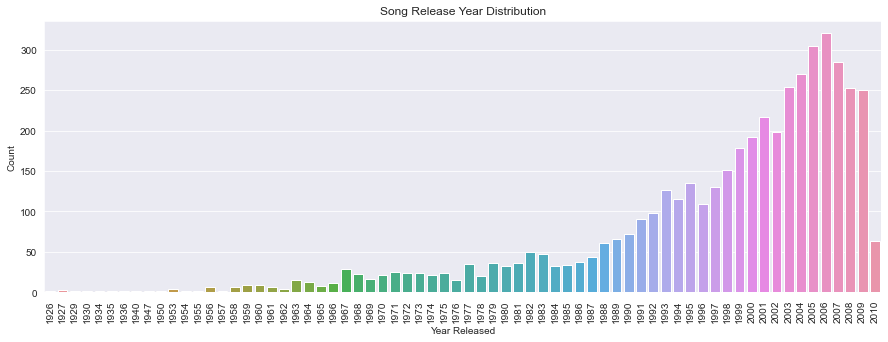

In [8]:
fig = plt.figure(figsize = (15, 5))
ax = sns.countplot(data = query_df, x = 'year')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90);
ax.set_xlabel('Year Released');
ax.set_ylabel('Count');
ax.set_title('Song Release Year Distribution');

Filtering out songs with invalid years leaves us with a set of 4,680 songs - 46.80% of the original data. From the graph above, we see that we have a range of songs from 1926 to 2010, but the majority of those songs are from the 1990s and 2000s.

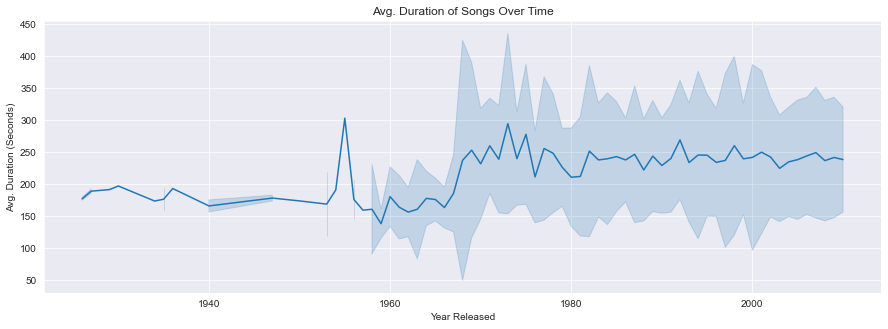

In [9]:
fig = plt.figure(figsize = (15, 5))
ax = sns.lineplot(data = query_df, x = 'year', y = 'duration', ci = 'sd')
ax.set_xlabel('Year Released');
ax.set_ylabel('Avg. Duration (Seconds)');
ax.set_title('Avg. Duration of Songs Over Time');

From this graph, we see that there seems to be an increase in song duration from the late 60s to the 70s, and then duration seems to stay the same from then on.

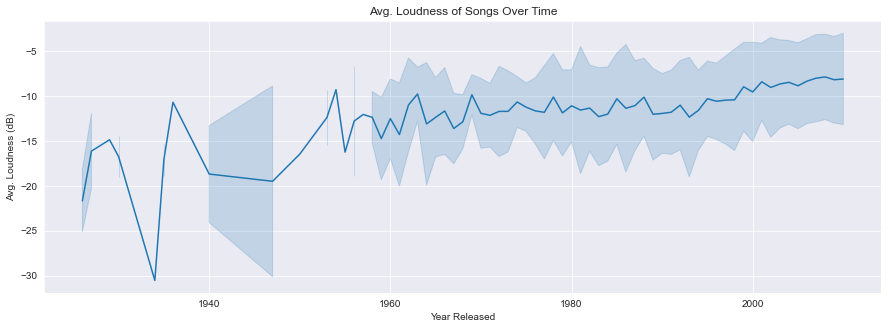

In [10]:
fig = plt.figure(figsize = (15, 5))
ax = sns.lineplot(data = query_df, x = 'year', y = 'loudness', ci = 'sd')
ax.set_xlabel('Year Released');
ax.set_ylabel('Avg. Loudness (dB)');
ax.set_title('Avg. Loudness of Songs Over Time');

We see these wild fluctuations before the 60s because there aren't that many songs in the data for that time period. Once we get a good amount of song data in the 60s onwards, we see that the loudness of songs looks to go up, albeit very slightly.

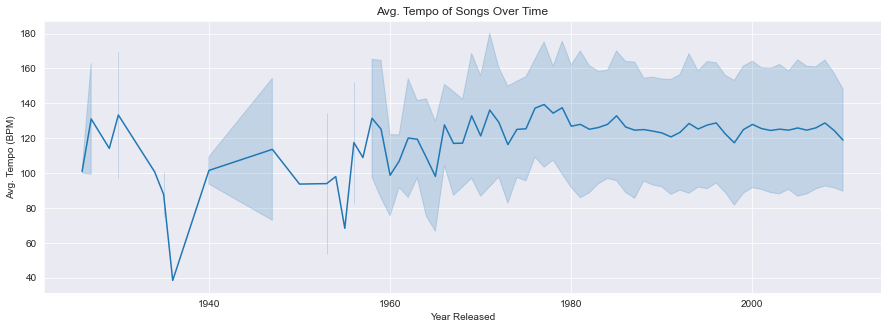

In [11]:
fig = plt.figure(figsize = (15, 5))
ax = sns.lineplot(data = query_df, x = 'year', y = 'tempo', ci = 'sd')
ax.set_xlabel('Year Released');
ax.set_ylabel('Avg. Tempo (BPM)');
ax.set_title('Avg. Tempo of Songs Over Time');

Song tempo seems to stay relatively constant, save for a bump from the 60s to the 70s and onwards.

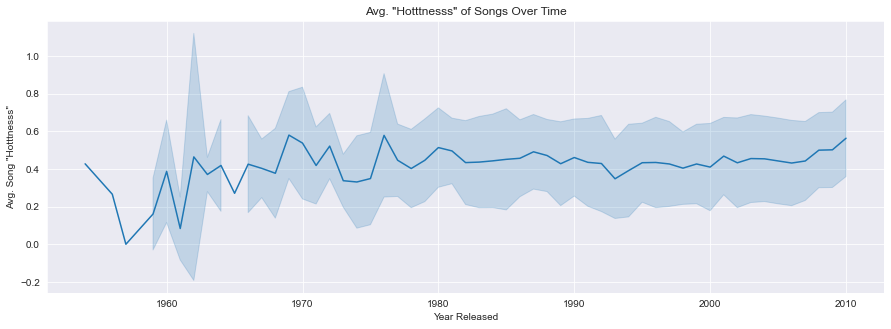

In [12]:
fig = plt.figure(figsize = (15, 5))
ax = sns.lineplot(data = query_df, x = 'year', y = 'song_hotttnesss', ci = 'sd')
ax.set_xlabel('Year Released');
ax.set_ylabel('Avg. Song "Hotttnesss"');
ax.set_title('Avg. "Hotttnesss" of Songs Over Time');

When it comes to song "hotttnesss," this value looks to stay relatively constant until the late 2000s where we see it starting to increase.

In [13]:
# Get the top 3 artist terms per year and their counts.
# If there are ties, they are ordered alphabetically.
query = f'''
    WITH grouped_year_artist_term_table AS (
        SELECT
            year,
            TRIM(artist_term) AS artist_term,
            COUNT(*) AS artist_term_count,
            ROW_NUMBER() OVER (
                PARTITION BY year ORDER BY COUNT(*) DESC, artist_term ASC
            ) AS ordered_count
        FROM {TABLE_NAME},
            UNNEST(artist_terms) AS artist_term
        WHERE year != 0
        GROUP BY year, artist_term
    )
    SELECT 
        year, 
        artist_term, 
        artist_term_count 
    FROM grouped_year_artist_term_table
    WHERE ordered_count <= 3
 '''

query_df = read_sql_with_copy(
    query = query, 
    db_engine = sqla_conn,
    convert_list_cols = False
)
print(query_df.shape)
query_df.head()

Running query...done!
(204, 3)


,year,artist_term,artist_term_count
0,1926,acoustic,2
1,1926,acoustic blues,2
2,1926,acoustic guitar,2
3,1927,acoustic blues,3
4,1927,american,3


In [14]:
tracks_90s_00s = query_df[query_df['year'] >= 1990]
tracks_70s_90s = query_df[
    (query_df['year'] >= 1970) &
    (query_df['year'] < 1990)
]
tracks_50s_70s = query_df[
    (query_df['year'] >= 1950) &
    (query_df['year'] < 1970)
]
tracks_30s_50s = query_df[
    (query_df['year'] >= 1930) &
    (query_df['year'] < 1950)
]
tracks_below_30s = query_df[query_df['year'] < 1930]

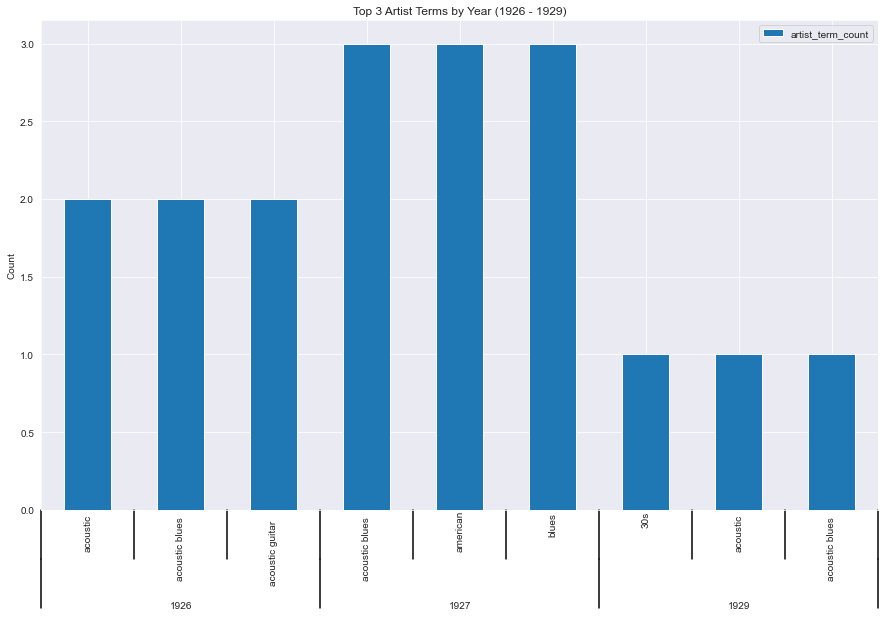

In [15]:
plot_artist_terms(tracks_below_30s)

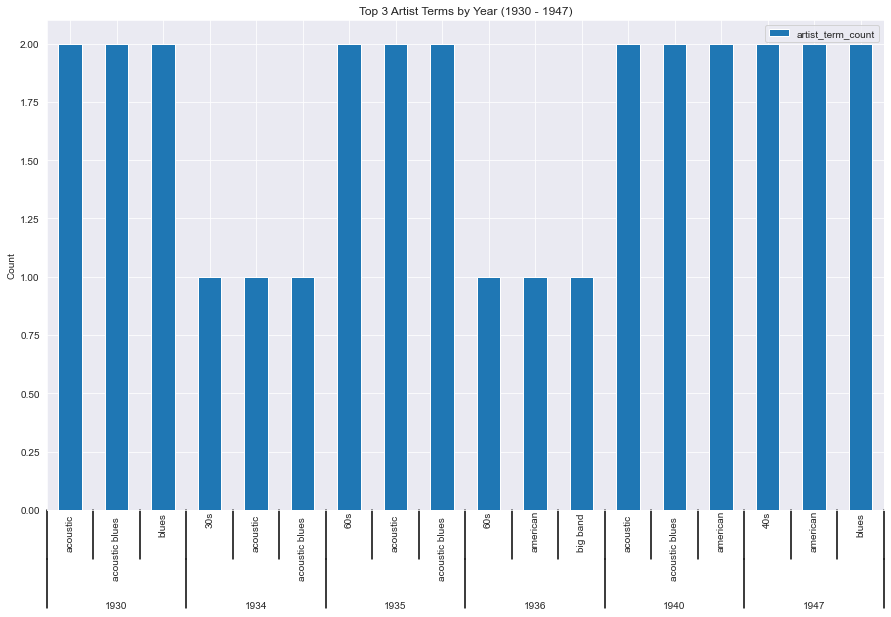

In [16]:
plot_artist_terms(tracks_30s_50s)

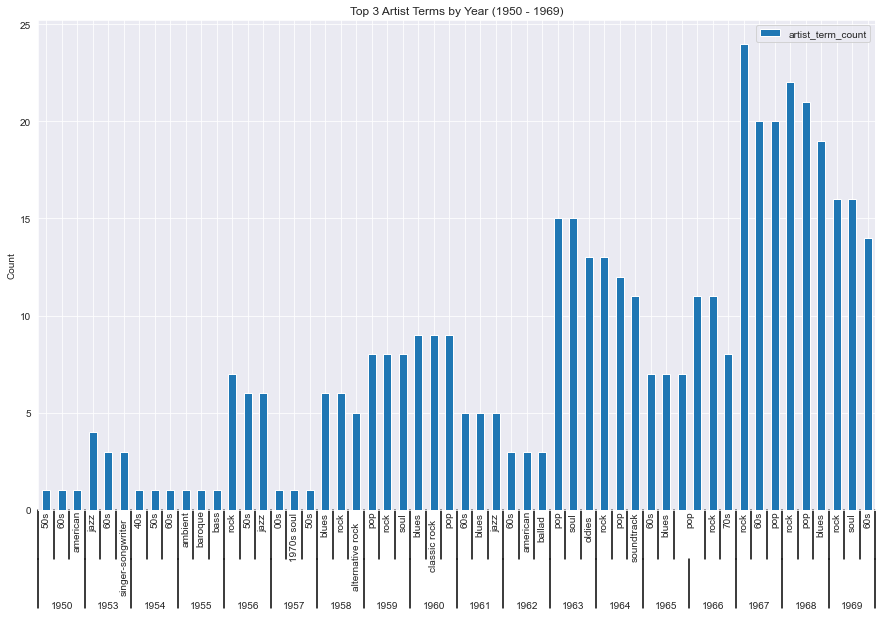

In [17]:
plot_artist_terms(tracks_50s_70s)

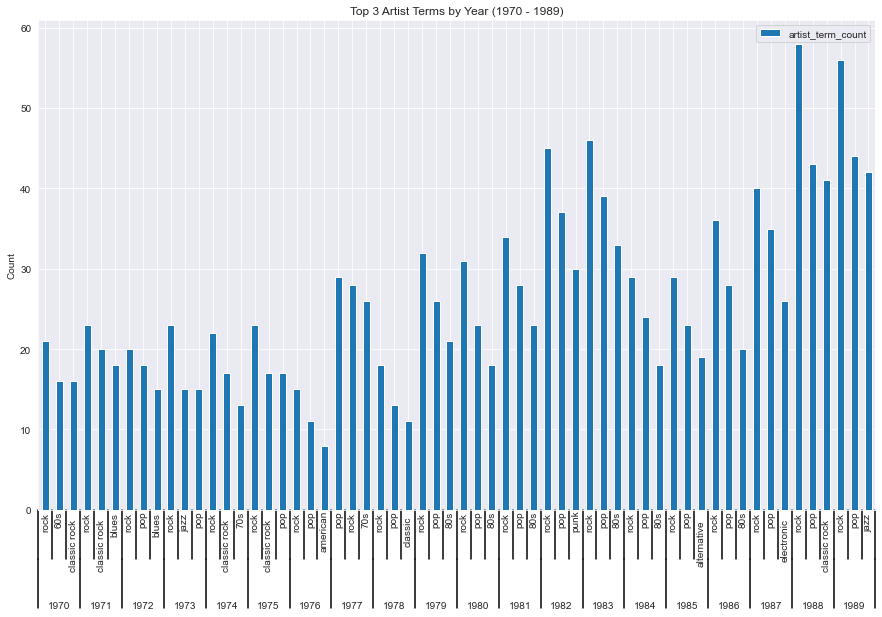

In [18]:
plot_artist_terms(tracks_70s_90s)

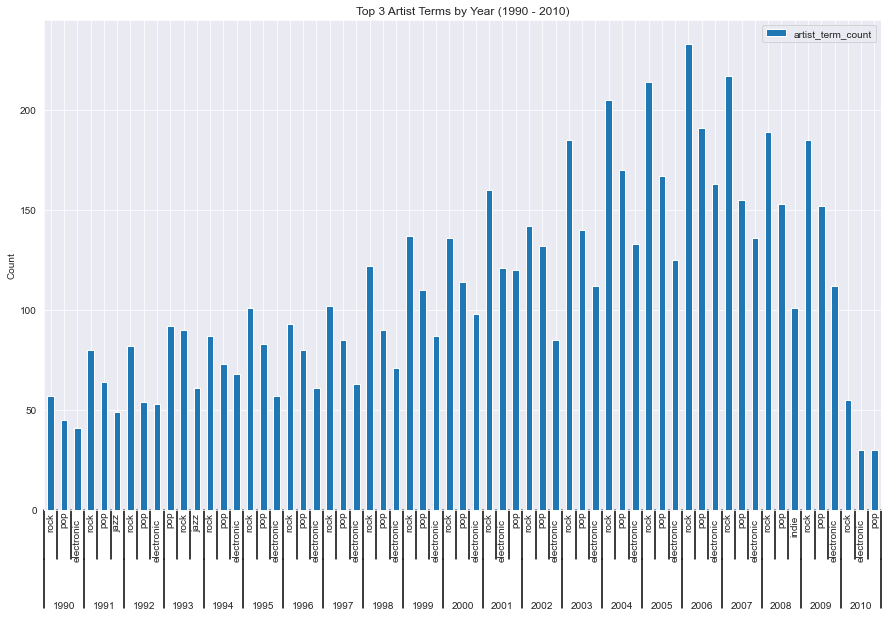

In [19]:
plot_artist_terms(tracks_90s_00s)